In [56]:
import pandas as pd
import os
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import warnings
from pandas.errors import SettingWithCopyWarning

# suppress pandas copy warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [57]:

# 1. LOAD EXPANDED DATASET & FILTER YEARS
# ---------------------------------------------------
mr = (
    pd.read_csv(
        "../10_Data/QQQ_MarketRisk.csv",
        parse_dates=["Date"]
    )
    .sort_values("Date")
    .query("Date.dt.year >= 2015 and Date.dt.year <= 2023")
    .reset_index(drop=True)
)

In [58]:
print(mr.sample(10))

           Date  QQQ_Return  QQQ_Realized_Volatility  QQQ_Volume        VIX  \
1281 2020-03-27   -0.034393                 0.900003    58845000  65.540001   
586  2017-06-22   -0.000285                 0.136634    24099100  10.480000   
210  2015-12-22    0.006574                 0.189013    26540300  16.600000   
2104 2023-07-06   -0.007616                 0.165701    49374700  15.440000   
288  2016-04-15   -0.002524                 0.127205    21353300  13.620000   
1417 2020-10-09    0.015280                 0.270611    30201100  25.000000   
746  2018-02-09    0.017270                 0.268399   113836600  29.059999   
1621 2021-08-03    0.006061                 0.103638    35558500  18.040001   
1177 2019-10-28    0.009865                 0.153295    18818700  13.110000   
136  2015-09-08    0.028191                 0.365393    37343500  24.900000   

         RSI_14        VXN  FedRate  
1281  47.033603  61.380001   -0.058  
586   41.169200  14.800000    0.933  
210   43.846345 

In [59]:
# 2. ENGINEER NEXT-DAY REALIZED VOLATILITY
# ---------------------------------------------------
mr["NextVol"] = mr["QQQ_Realized_Volatility"].shift(-1)

In [60]:
# 3. SELECT FEATURES & CLEAN
# ---------------------------------------------------
features = [
    "QQQ_Return",
    "QQQ_Realized_Volatility",
    "QQQ_Volume",
    "VIX",
    "RSI_14",
    "VXN",
    "FedRate",
]

# coerce numeric, drop any rows missing features or target
for col in features + ["NextVol"]:
    mr[col] = pd.to_numeric(mr[col], errors="coerce")

mr.dropna(subset=features + ["NextVol"], inplace=True)
mr.reset_index(drop=True, inplace=True)

In [61]:
# 4. ROLLING 3-YEAR WINDOW → PREDICT ONLY FOR 2020–2023
# ---------------------------------------------------
results = []
first_date = mr["Date"].min()

for _, row in mr.iterrows():
    today = row["Date"]
    year  = today.year

    # only record predictions in test window
    if year < 2020 or year > 2023:
        continue

    # require 3 full years of history
    if today < (first_date + pd.DateOffset(years=3)):
        continue

    # build train window [today - 3y, today)
    window_start = today - pd.DateOffset(years=3)
    train_df     = mr[(mr["Date"] >= window_start) & (mr["Date"] < today)]

    # skip if too few training rows
    if len(train_df) < 200:
        continue

    X_train = train_df[features]
    y_train = train_df["NextVol"]

    # today's features → one‐step forecast
    X_today = row[features].values.reshape(1, -1)
    y_true  = row["NextVol"]

    # train & predict
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=50,
        learning_rate=0.05,
        random_state=42,
    )
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_today)[0]

    results.append({
        "Date":              today,
        "PredictedNextVol":  y_pred,
        "ActualNextVol":     y_true
    })

In [62]:
# 5. ASSEMBLE & SAVE
# ---------------------------------------------------
out_df = pd.DataFrame(results)
out_df.to_csv("rolling_4yr_preds_2020_23.csv", index=False)
print(f"Saved {len(out_df)} predictions → rolling_3yr_preds_2020_23.csv")

Saved 1005 predictions → rolling_3yr_preds_2020_23.csv


        Date  PredictedNextVol  ActualNextVol
0 2020-01-02          0.098806       0.095004
1 2020-01-03          0.100286       0.095491
2 2020-01-06          0.098931       0.096089
3 2020-01-07          0.102293       0.093481
4 2020-01-08          0.098353       0.091340


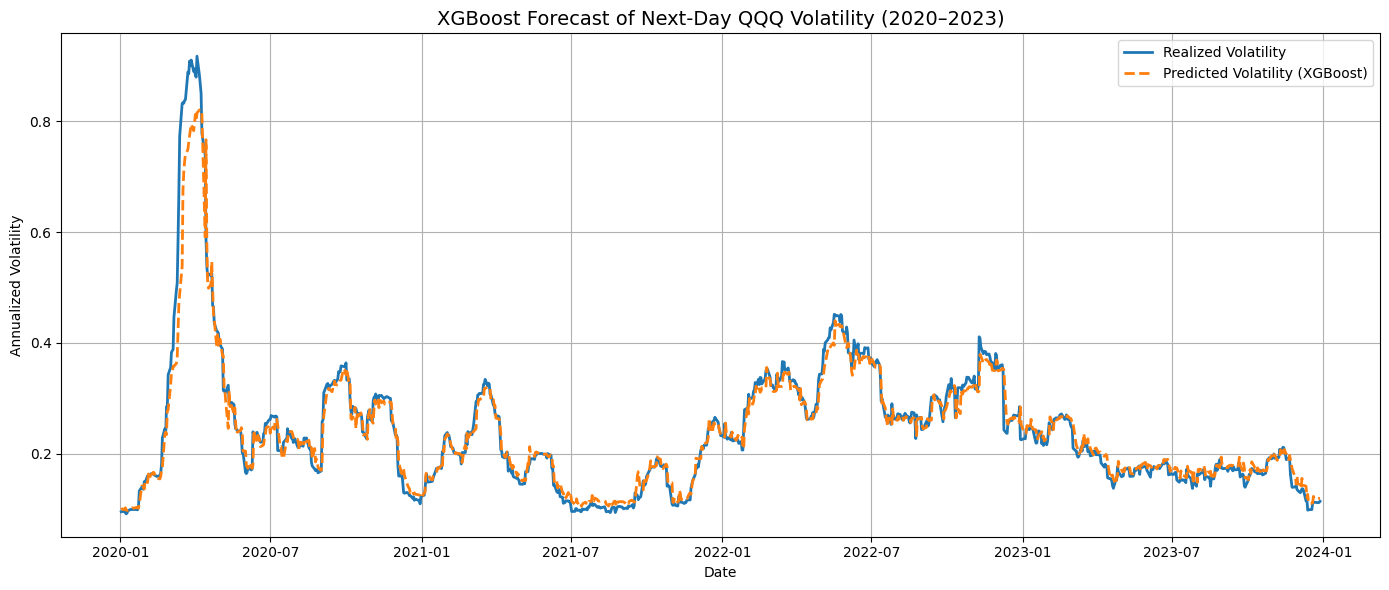

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# 6.  XGBoost Forecast of Next-Day QQQ Volatility Using Rolling 3-Year Window (2020–2023).
# ---------------------------------------------------

# Load predictions
df = pd.read_csv('../20_RiskModel/rolling_4yr_preds_2020_23.csv', parse_dates=['Date'])
print(df.head())

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['ActualNextVol'], label='Realized Volatility', linewidth=2)
plt.plot(df['Date'], df['PredictedNextVol'], label='Predicted Volatility (XGBoost)', linestyle='--', linewidth=2)

plt.title('XGBoost Forecast of Next-Day QQQ Volatility (2020–2023)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
# 7. COMPUTE TEST METRICS (2020–2023)
# ---------------------------------------------------
y_pred = out_df["PredictedNextVol"]
y_true = out_df["ActualNextVol"]

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print("\n--- Test Metrics (2020–2023) ---")
print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test R²  : {r2:.4f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test MAPE: {mape:.2%}")


--- Test Metrics (2020–2023) ---
Test MSE : 0.000777
Test RMSE: 0.027880
Test R²  : 0.9522
Test MAE : 0.014612
Test MAPE: 5.91%


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


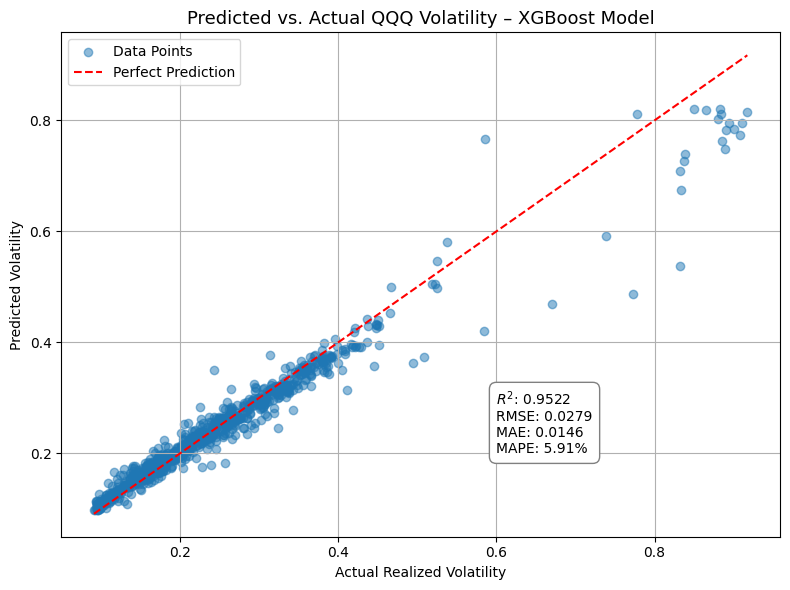

In [65]:
# 8. Predicted vs. Actual Volatility with Performance Metrics of XGBoost Model
# ---------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df = pd.read_csv('rolling_4yr_preds_2020_23.csv')

# True and predicted values
y_true = df['ActualNextVol']
y_pred = df['PredictedNextVol']

# Compute metrics
r2 = r2_score(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='Data Points')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')

# Add metrics as text box
metrics_text = (
    f"$R^2$: {r2:.4f}\n"
    f"RMSE: {rmse:.4f}\n"
    f"MAE: {mae:.4f}\n"
    f"MAPE: {mape:.2f}%"
)

plt.text(
    0.6, 0.2, metrics_text,
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
)

# Titles and labels
plt.title('Predicted vs. Actual QQQ Volatility – XGBoost Model', fontsize=13)
plt.xlabel('Actual Realized Volatility')
plt.ylabel('Predicted Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
